## Introduction
In this lab, we will learn how to use Scikit-Learn's IterativeImputer class to impute missing values in a dataset. We will compare different estimators to see which one is best for the IterativeImputer when using a BayesianRidge estimator on the California housing dataset with a single value randomly removed from each row.

## Import Libraries
We will first import the necessary libraries for this lab.

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.experimental import enable_iterative_imputer
from sklearn.datasets import fetch_california_housing
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.kernel_approximation import Nystroem
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

## Load Dataset
We will load the California housing dataset from Scikit-Learn. We will only use 2k samples to reduce the computational time.

In [46]:
N_SPLITS = 5

rng = np.random.RandomState(0)

X_full, y_full = fetch_california_housing(return_X_y=True)
X_full = X_full[::10]
y_full = y_full[::10]
n_samples, n_features = X_full.shape

In [47]:
estimator = BayesianRidge()
score_full_data = pd.DataFrame()
score_full_data["BayesianRidge"] = cross_val_score(
    estimator, X_full, y_full, scoring="neg_mean_squared_error", cv=N_SPLITS
)

## Add Missing Values
We will add a single missing value to each row of the dataset.

In [48]:
X_missing = X_full.copy()
y_missing = y_full
missing_samples = np.arange(n_samples)
missing_features = rng.choice(n_features, n_samples, replace=True)
X_missing[missing_samples, missing_features] = np.nan

## Impute Missing Values with Simple Imputer
We will use Scikit-Learn's SimpleImputer class to impute missing values using mean and median strategies.

In [49]:
score_simple_imputer = pd.DataFrame()
for strategy in ("mean", "median"):
    estimator = make_pipeline(
        SimpleImputer(missing_values=np.nan, strategy=strategy), BayesianRidge()
    )
    score_simple_imputer[strategy] = cross_val_score(
        estimator, X_missing, y_missing, scoring="neg_mean_squared_error", cv=N_SPLITS
    )

## Impute Missing Values with Iterative Imputer
We will use Scikit-Learn's IterativeImputer class to impute missing values using different estimators.

In [50]:
estimators = [
    BayesianRidge(),
    RandomForestRegressor(
        n_estimators=4,
        max_depth=10,
        bootstrap=True,
        max_samples=0.5,
        n_jobs=2,
        random_state=0,
    ),
    make_pipeline(
        Nystroem(kernel="polynomial", degree=2, random_state=0), Ridge(alpha=1e3)
    ),
    KNeighborsRegressor(n_neighbors=15),
]
score_iterative_imputer = pd.DataFrame()
tolerances = (1e-3, 1e-1, 1e-1, 1e-2)
for impute_estimator, tol in zip(estimators, tolerances):
    estimator = make_pipeline(
        IterativeImputer(
            random_state=0, estimator=impute_estimator, max_iter=25, tol=tol
        ),
        BayesianRidge(),
    )
    score_iterative_imputer[impute_estimator.__class__.__name__] = cross_val_score(
        estimator, X_missing, y_missing, scoring="neg_mean_squared_error", cv=N_SPLITS
    )

## Compare Results
We will compare the results of different imputation strategies using a bar chart.

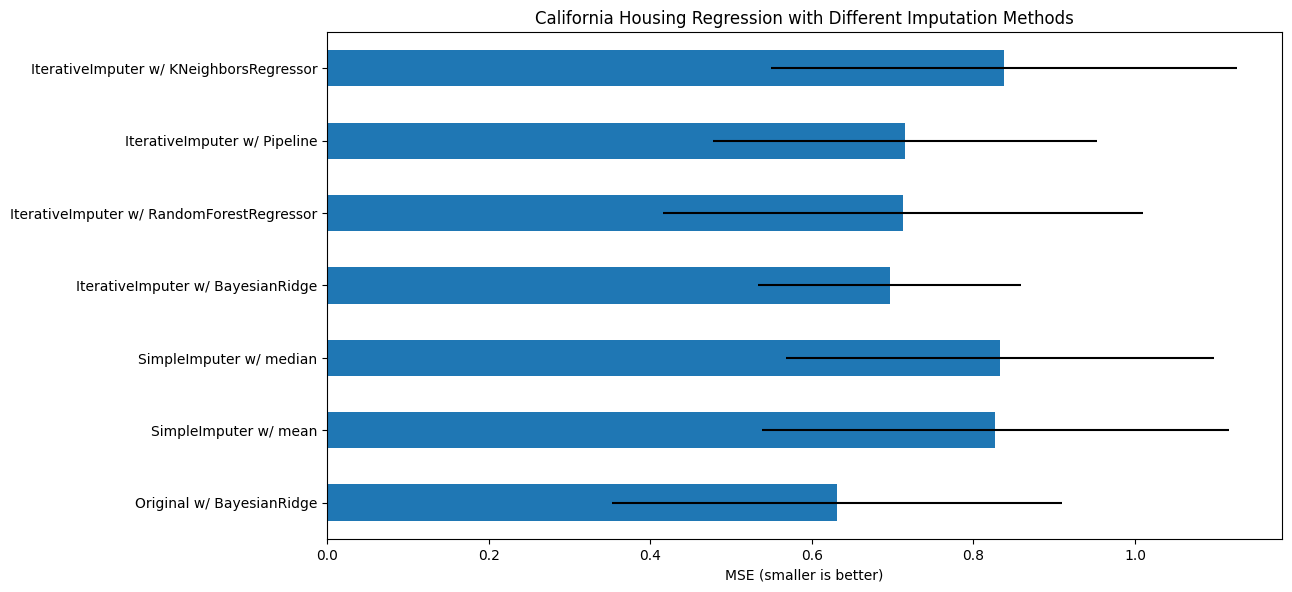

In [51]:
scores = pd.concat(
    [score_full_data, score_simple_imputer, score_iterative_imputer],
    keys=["Original", "SimpleImputer", "IterativeImputer"],
    axis=1,
)

fig, ax = plt.subplots(figsize=(13, 6))
means = -scores.mean()
errors = scores.std()
means.plot.barh(xerr=errors, ax=ax)
ax.set_title("California Housing Regression with Different Imputation Methods")
ax.set_xlabel("MSE (smaller is better)")
ax.set_yticks(np.arange(means.shape[0]))
ax.set_yticklabels([" w/ ".join(label) for label in means.index.tolist()])
plt.tight_layout(pad=1)
plt.show()

## Summary
In this lab, we learned how to use Scikit-Learn's IterativeImputer class to impute missing values in a dataset. We compared different imputation strategies using mean and median imputation with SimpleImputer and different estimators with IterativeImputer. We found that BayesianRidge and RandomForestRegressor gave the best results for this particular pattern of missing values in the California housing dataset.